In [58]:
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier


In [59]:
np.random.seed(42)

#### Utility functions

In [60]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float32', 'float64']  # Removed float16
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                # Skip float16 to avoid overflow issues with pandas display
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [61]:
def visualize_class_distribution(y):
    class0 = (y == 0).sum()
    class1 = (y == 1).sum()

    data = {
        'Class': ['Class 0', 'Class 1'],
        'Count': [class0, class1]
    }

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Class', y='Count', data=data)
    plt.title('Class Distribution (Train Set)')
    plt.show()

### Data Collection
- Import the data from Kaggle [Santander Customer Transaction Prediction Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/data)
- Visualize the data: 
    - Check the size and type of data.
- Convert data to practical formats


In [62]:
# Download the dataset first to see what files are available
dataset_path = kagglehub.dataset_download("lakshmi25npathi/santander-customer-transaction-prediction-dataset")

print(f"Dataset downloaded to: {dataset_path}")
print("\nFiles in the dataset:")
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(f"  - {file}")


Dataset downloaded to: C:\Users\jdorn\.cache\kagglehub\datasets\lakshmi25npathi\santander-customer-transaction-prediction-dataset\versions\1

Files in the dataset:
  - test.csv
  - train.csv


In [63]:
df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

#### Dataset visualization

In [64]:
df.shape

(200000, 202)

In [65]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


### Exploration Data Analysis (EDA)

- Downsampling a copy of the dataset
- Check data type
- Data cleaning
    - Fill in missing values (empty or NaN) or drop their rows
    - Fix or Remove outliers
- Feature selection
    - Drop non relevant columns
- Feature engineering
    - Possibly discretize continuous features
    - Decompose features (e.g., categorical, date/time)
    - Add promising feature transformations (e.g., log(x), x^2)
    - Aggregate features into promising new features
- Normalization

Data cleaning

In [67]:
#Check empty values in each column
empty = df.isna().sum()
print(empty[empty>0])
# Show rows with any null values
df[df.isnull().any(axis=1)]

Series([], dtype: int64)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199


In [68]:
df['target'].value_counts()

target
0    179902
1     20098
Name: count, dtype: int64

In [69]:
# Remove the ID_code column
df = df.drop(columns=['ID_code'])
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [70]:
# Remove outliers
total_outliers = 0

# Detect outliers using the IQR method

outlier_indices = set()

for col in df.columns.drop('target'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_idx = df[outlier_mask].index.tolist()
    
    #print(f"Column: {col}, Outliers detected: {len(outlier_idx)}")
    
    # Add indices to the set (automatically removes duplicates)
    outlier_indices.update(outlier_idx)
    total_outliers += len(outlier_idx)
print(f"Total outliers detected across all columns: {total_outliers}")
print(f"Total unique rows with outliers: {len(outlier_indices)}")

# (Optional) View the unique outlier rows
outlier_rows = df.loc[list(outlier_indices)]
print(f"\nOutlier rows shape: {outlier_rows.shape}")

Total outliers detected across all columns: 26536
Total unique rows with outliers: 24896

Outlier rows shape: (24896, 201)


In [ ]:
# Check non numeric columns to transform data into a more efficient type for the training
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
non_numeric_cols

In [71]:
# remove outlier rows from the original dataframe
df_cleaned = df.drop(index=outlier_indices)
df_cleaned.shape

(175104, 201)

Split test and train sets

In [72]:
X = df_cleaned.drop(columns=['target'])
y = df_cleaned['target']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

Visualize target values

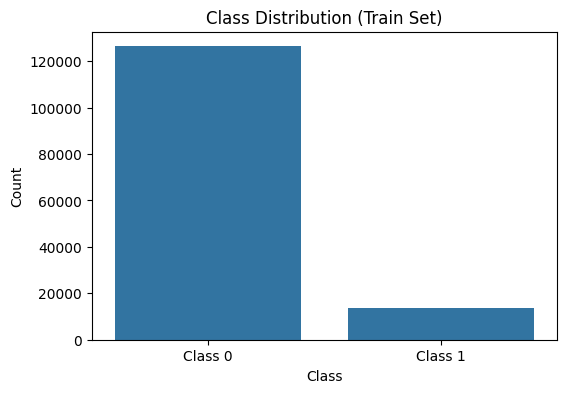

In [74]:
visualize_class_distribution(y_train)

We see an imbalance dataset. Solution:
- Doing downsampling on a copy of the training dataset to evaluate the performance
- Doing class weighted on the models

We don't do upsample because we want to minimize training time.

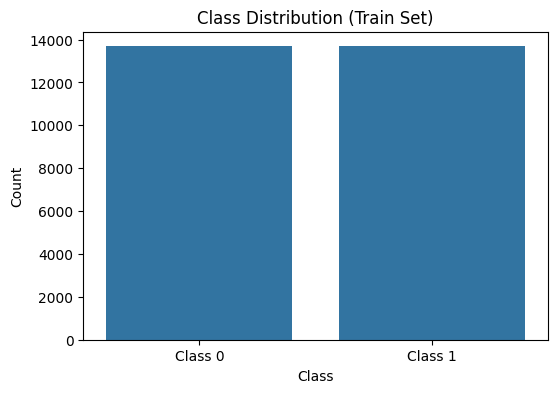

In [75]:
# Downsampling
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled_down, y_resampled_down = rus.fit_resample(X_train_copy, y_train_copy)
visualize_class_distribution(y_resampled_down)

In [78]:
# Class weigthing
class_weights = {0: 1, 1: round((len(y_train) / sum(y_train)),2)}  # Adjust weights based on class distribution
print(f"Class weights: {class_weights}")

Class weights: {0: 1, 1: 10.24}


Correlation matrix

In [ ]:
scorr = df_cleaned.corr(numeric_only=True)
scorr

In [ ]:
np.fill_diagonal(scorr.values, 0)
top_pairs = scorr.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_4_pairs = top_pairs.head(10)
print("Top 4 correlated pairs:\n", top_4_pairs)

Standardization

In [ ]:
# Standardize the features of the inbalanced dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Standardize the features of the balanced dataset (downsample)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled_down)
X_test_scaled = scaler.transform(X_test)

### Models fitting